In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torchvision.utils as vutils
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

# download path 정의
download_root = './MNIST_DATASET'

In [3]:
# Normalize data with mean=0.5, std=1.0
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.5,), (1.0,))
])

In [4]:
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
train_dataset.data.shape, test_dataset.data.shape, train_dataset.targets.shape, test_dataset.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [5]:
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_loader = torch.utils.data.DataLoader(dataset=all_dataset, 
                         batch_size=batch_size,
                         shuffle=True, drop_last=True)
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args[0]

    def forward(self, x):
        return x.view(self.shape)

In [7]:
class Generator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(generator_in_channels, 7 * 7 * generator_in_channels),
            nn.LeakyReLU(0.2),
            Reshape((-1, generator_in_channels,7,7)),
            nn.ConvTranspose2d(generator_in_channels, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, (7,7)),
            nn.Sigmoid())
    def forward(self, noise, one_hot_labels):
        random_vector_labels = torch.cat(
            (noise, one_hot_labels), 1
        )
        generated_images = self.generator(random_vector_labels)
        return generated_images

In [8]:
class Discriminator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(discriminator_in_channels, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(128,1))
    def forward(self, images, one_hot_labels):
        image_size = images.shape[2]
        
#         image_one_hot_labels = one_hot_labels[:,:,None,None]
        image_one_hot_labels = one_hot_labels.repeat_interleave(
            torch.tensor(image_size*image_size).to(device)
        )
        image_one_hot_labels = image_one_hot_labels.view(
            (-1, num_classes, image_size, image_size)
        )
#         image_one_hot_labels = image_one_hot_labels.permute(0,3,1,2)
        images_and_labels = torch.cat((images, image_one_hot_labels), 1)
        predictions = self.discriminator(images_and_labels)
        return predictions, images_and_labels

In [9]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003)
criterion = torch.nn.BCEWithLogitsLoss().to(device)

epochs = 20

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear) :
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [12]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AdaptiveMaxPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Epoch: [0][0/1093]	generator_loss: 0.6550 (0.6550)	discriminator_loss: 0.6942 (0.6942)	
Epoch: [0][200/1093]	generator_loss: 3.5903 (2.9443)	discriminator_loss: 0.0676 (0.1621)	
Epoch: [0][400/1093]	generator_loss: 6.2661 (4.0926)	discriminator_loss: 0.0027 (0.1527)	
Epoch: [0][600/1093]	generator_loss: 3.2641 (4.4692)	discriminator_loss: 0.0689 (0.1478)	
Epoch: [0][800/1093]	generator_loss: 0.9800 (3.8903)	discriminator_loss: 0.8612 (0.2151)	
Epoch: [0][1000/1093]	generator_loss: 1.5168 (3.3604)	discriminator_loss: 0.3267 (0.2876)	


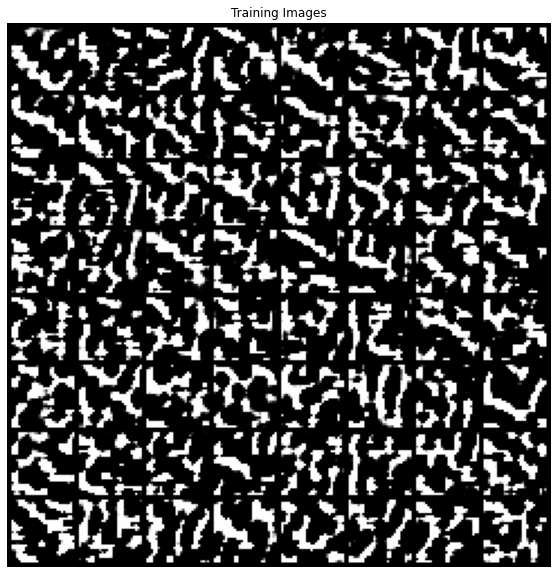

Epoch: [1][0/1093]	generator_loss: 1.3300 (1.3300)	discriminator_loss: 0.4260 (0.4260)	
Epoch: [1][200/1093]	generator_loss: 2.0189 (1.6586)	discriminator_loss: 0.3466 (0.4204)	
Epoch: [1][400/1093]	generator_loss: 1.7771 (1.8428)	discriminator_loss: 0.2452 (0.3754)	
Epoch: [1][600/1093]	generator_loss: 1.2073 (1.8859)	discriminator_loss: 0.4527 (0.3521)	
Epoch: [1][800/1093]	generator_loss: 2.3084 (2.0109)	discriminator_loss: 0.3031 (0.3281)	
Epoch: [1][1000/1093]	generator_loss: 2.5179 (2.0554)	discriminator_loss: 0.3073 (0.3174)	


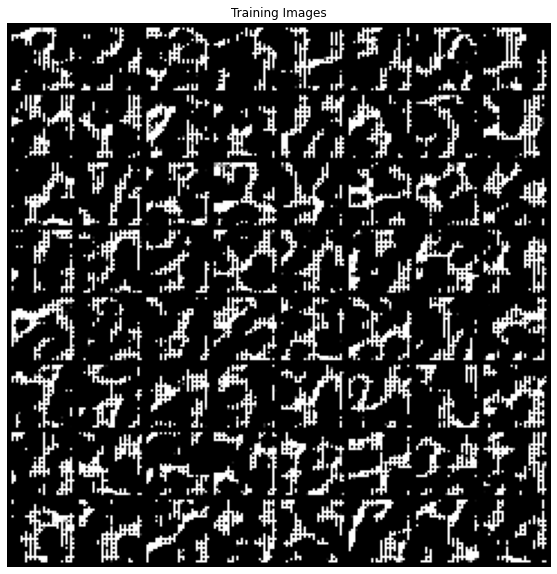

Epoch: [2][0/1093]	generator_loss: 2.5131 (2.5131)	discriminator_loss: 0.2104 (0.2104)	
Epoch: [2][200/1093]	generator_loss: 2.5986 (2.8528)	discriminator_loss: 0.1873 (0.2083)	
Epoch: [2][400/1093]	generator_loss: 3.7731 (2.7355)	discriminator_loss: 0.0336 (0.2134)	
Epoch: [2][600/1093]	generator_loss: 3.8376 (2.8692)	discriminator_loss: 0.1224 (0.2000)	
Epoch: [2][800/1093]	generator_loss: 2.4703 (2.8934)	discriminator_loss: 0.2685 (0.1976)	
Epoch: [2][1000/1093]	generator_loss: 3.4602 (3.0238)	discriminator_loss: 0.1284 (0.1814)	


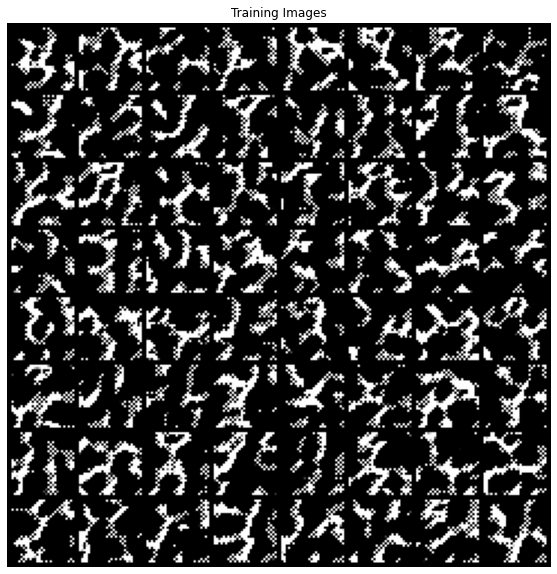

Epoch: [3][0/1093]	generator_loss: 3.4205 (3.4205)	discriminator_loss: 0.1591 (0.1591)	
Epoch: [3][200/1093]	generator_loss: 2.8236 (3.4455)	discriminator_loss: 0.1069 (0.1168)	
Epoch: [3][400/1093]	generator_loss: 3.7105 (3.4602)	discriminator_loss: 0.0684 (0.1135)	
Epoch: [3][600/1093]	generator_loss: 3.7927 (3.5397)	discriminator_loss: 0.0746 (0.1101)	
Epoch: [3][800/1093]	generator_loss: 3.1737 (3.6148)	discriminator_loss: 0.1131 (0.1060)	
Epoch: [3][1000/1093]	generator_loss: 4.0202 (3.6793)	discriminator_loss: 0.0979 (0.1014)	


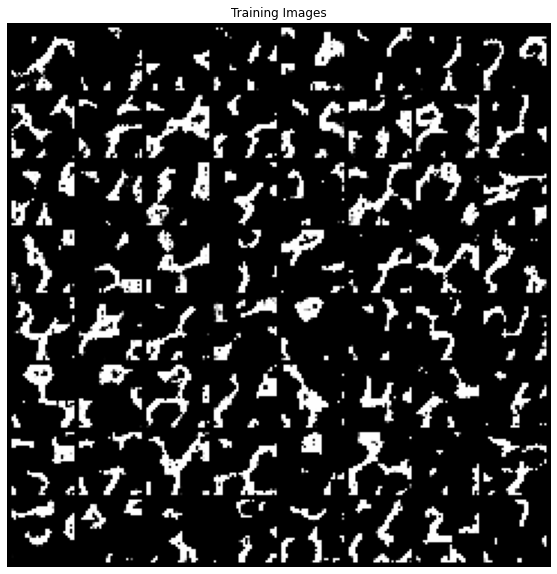

Epoch: [4][0/1093]	generator_loss: 4.2152 (4.2152)	discriminator_loss: 0.0748 (0.0748)	
Epoch: [4][200/1093]	generator_loss: 4.4965 (4.1083)	discriminator_loss: 0.0513 (0.0710)	
Epoch: [4][400/1093]	generator_loss: 4.7747 (4.2207)	discriminator_loss: 0.0455 (0.0650)	
Epoch: [4][600/1093]	generator_loss: 4.2310 (4.2481)	discriminator_loss: 0.0406 (0.0631)	
Epoch: [4][800/1093]	generator_loss: 3.6929 (4.1711)	discriminator_loss: 0.2013 (0.0690)	
Epoch: [4][1000/1093]	generator_loss: 2.2628 (3.7449)	discriminator_loss: 0.3561 (0.1437)	


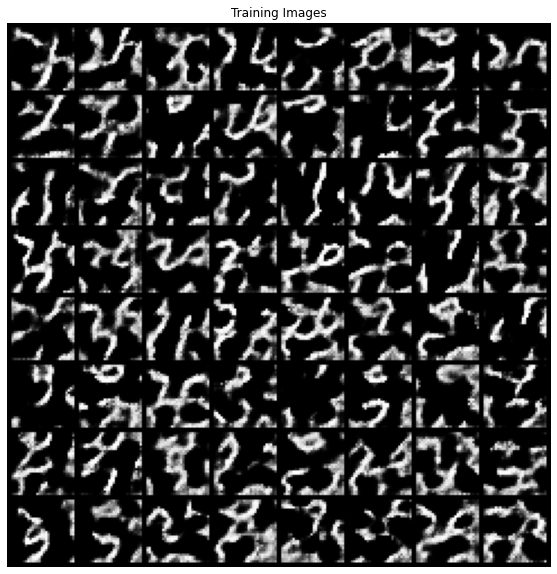

Epoch: [5][0/1093]	generator_loss: 2.1033 (2.1033)	discriminator_loss: 0.3020 (0.3020)	
Epoch: [5][200/1093]	generator_loss: 2.1038 (1.8470)	discriminator_loss: 0.4210 (0.3777)	
Epoch: [5][400/1093]	generator_loss: 1.6076 (1.9567)	discriminator_loss: 0.3384 (0.3700)	
Epoch: [5][600/1093]	generator_loss: 1.2727 (1.9141)	discriminator_loss: 0.5061 (0.3864)	
Epoch: [5][800/1093]	generator_loss: 1.7856 (1.8288)	discriminator_loss: 0.5529 (0.4014)	
Epoch: [5][1000/1093]	generator_loss: 2.0213 (1.7993)	discriminator_loss: 0.4021 (0.4087)	


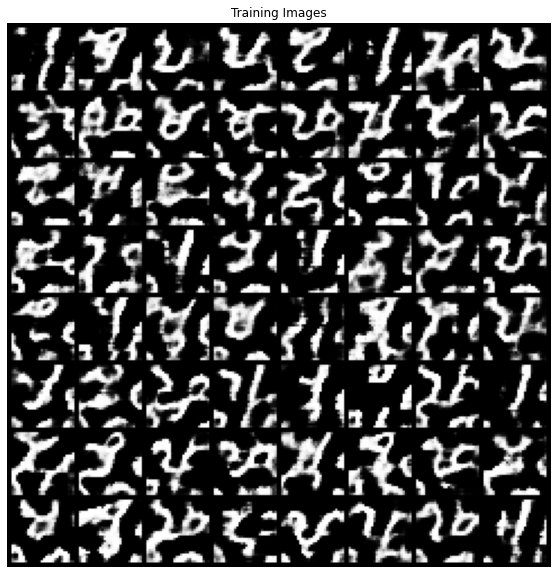

Epoch: [6][0/1093]	generator_loss: 1.8351 (1.8351)	discriminator_loss: 0.4243 (0.4243)	
Epoch: [6][200/1093]	generator_loss: 1.9221 (1.5693)	discriminator_loss: 0.4522 (0.4601)	
Epoch: [6][400/1093]	generator_loss: 1.6946 (1.5102)	discriminator_loss: 0.3942 (0.4650)	
Epoch: [6][600/1093]	generator_loss: 1.8431 (1.5406)	discriminator_loss: 0.4596 (0.4592)	
Epoch: [6][800/1093]	generator_loss: 1.7629 (1.5538)	discriminator_loss: 0.5305 (0.4600)	
Epoch: [6][1000/1093]	generator_loss: 1.0149 (1.5402)	discriminator_loss: 0.5311 (0.4663)	


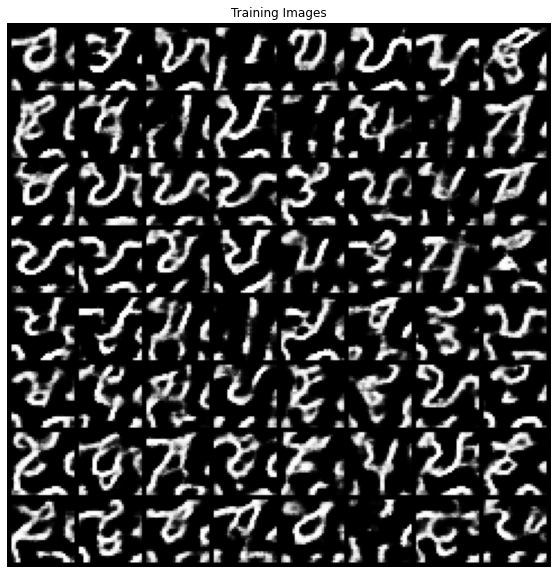

Epoch: [7][0/1093]	generator_loss: 1.5395 (1.5395)	discriminator_loss: 0.5649 (0.5649)	
Epoch: [7][200/1093]	generator_loss: 1.0584 (1.3876)	discriminator_loss: 0.6377 (0.4821)	
Epoch: [7][400/1093]	generator_loss: 1.3325 (1.3944)	discriminator_loss: 0.5722 (0.4859)	
Epoch: [7][600/1093]	generator_loss: 1.8762 (1.3949)	discriminator_loss: 0.3823 (0.4877)	
Epoch: [7][800/1093]	generator_loss: 1.4696 (1.4008)	discriminator_loss: 0.4077 (0.4891)	
Epoch: [7][1000/1093]	generator_loss: 1.3648 (1.3889)	discriminator_loss: 0.4680 (0.4914)	


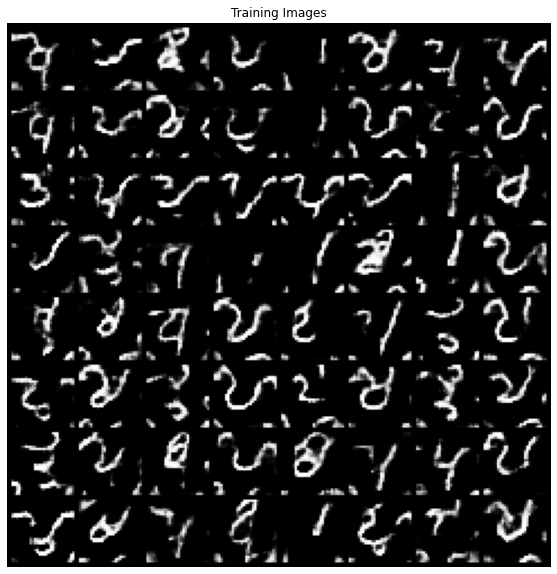

Epoch: [8][0/1093]	generator_loss: 1.6808 (1.6808)	discriminator_loss: 0.3304 (0.3304)	
Epoch: [8][200/1093]	generator_loss: 1.6968 (1.3613)	discriminator_loss: 0.4181 (0.5105)	
Epoch: [8][400/1093]	generator_loss: 1.1832 (1.3703)	discriminator_loss: 0.5207 (0.5110)	
Epoch: [8][600/1093]	generator_loss: 1.3579 (1.3487)	discriminator_loss: 0.5733 (0.5144)	
Epoch: [8][800/1093]	generator_loss: 1.0704 (1.3294)	discriminator_loss: 0.6151 (0.5146)	
Epoch: [8][1000/1093]	generator_loss: 1.2229 (1.3215)	discriminator_loss: 0.5880 (0.5164)	


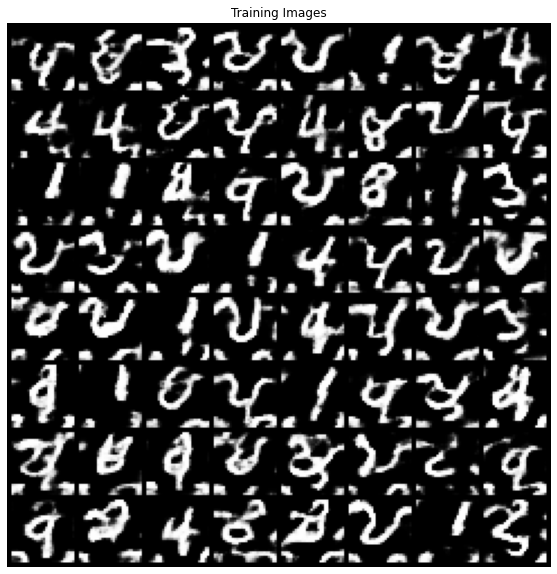

Epoch: [9][0/1093]	generator_loss: 1.4567 (1.4567)	discriminator_loss: 0.4938 (0.4938)	
Epoch: [9][200/1093]	generator_loss: 0.9361 (1.2613)	discriminator_loss: 0.5684 (0.5432)	
Epoch: [9][400/1093]	generator_loss: 1.2296 (1.2580)	discriminator_loss: 0.4796 (0.5378)	
Epoch: [9][600/1093]	generator_loss: 1.1333 (1.2370)	discriminator_loss: 0.5090 (0.5397)	
Epoch: [9][800/1093]	generator_loss: 1.0789 (1.2243)	discriminator_loss: 0.5787 (0.5398)	
Epoch: [9][1000/1093]	generator_loss: 1.0475 (1.2105)	discriminator_loss: 0.4720 (0.5396)	


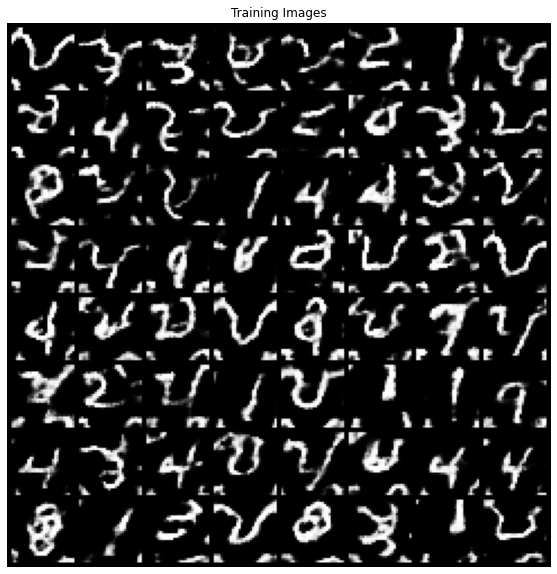

Epoch: [10][0/1093]	generator_loss: 1.2432 (1.2432)	discriminator_loss: 0.4943 (0.4943)	
Epoch: [10][200/1093]	generator_loss: 1.6012 (1.2553)	discriminator_loss: 0.4173 (0.5322)	
Epoch: [10][400/1093]	generator_loss: 1.2088 (1.2993)	discriminator_loss: 0.5315 (0.5345)	
Epoch: [10][600/1093]	generator_loss: 1.3455 (1.3009)	discriminator_loss: 0.4485 (0.5318)	
Epoch: [10][800/1093]	generator_loss: 1.1785 (1.2744)	discriminator_loss: 0.4970 (0.5323)	
Epoch: [10][1000/1093]	generator_loss: 1.5673 (1.2712)	discriminator_loss: 0.4073 (0.5316)	


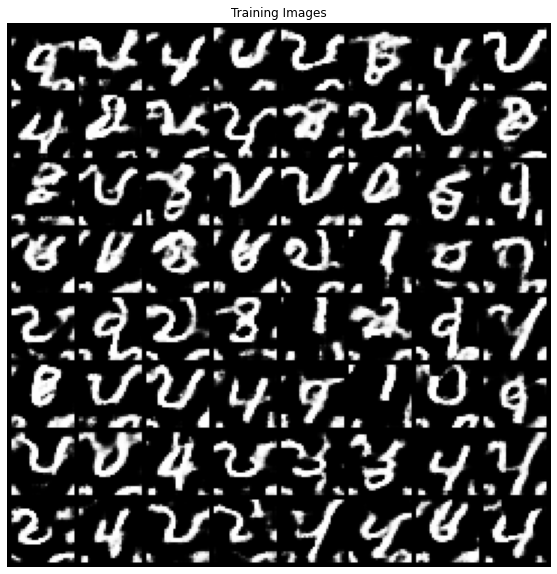

Epoch: [11][0/1093]	generator_loss: 1.1627 (1.1627)	discriminator_loss: 0.4668 (0.4668)	
Epoch: [11][200/1093]	generator_loss: 1.1786 (1.2280)	discriminator_loss: 0.5965 (0.5287)	
Epoch: [11][400/1093]	generator_loss: 1.1142 (1.2059)	discriminator_loss: 0.5141 (0.5304)	
Epoch: [11][600/1093]	generator_loss: 1.1097 (1.2119)	discriminator_loss: 0.6087 (0.5299)	
Epoch: [11][800/1093]	generator_loss: 1.2259 (1.2231)	discriminator_loss: 0.5194 (0.5310)	
Epoch: [11][1000/1093]	generator_loss: 1.1960 (1.2230)	discriminator_loss: 0.5044 (0.5333)	


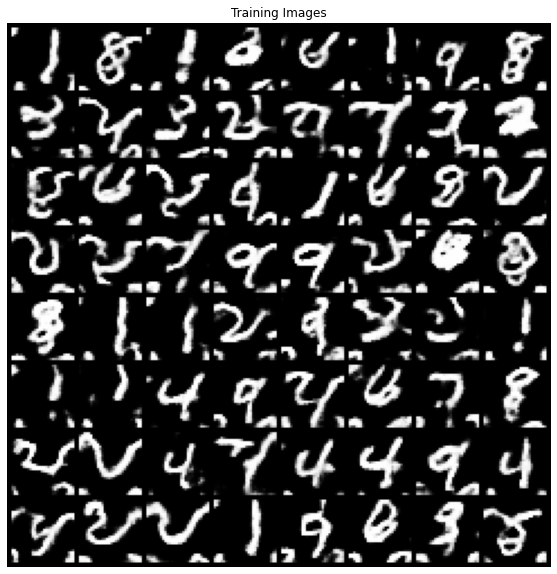

Epoch: [12][0/1093]	generator_loss: 1.2539 (1.2539)	discriminator_loss: 0.4797 (0.4797)	
Epoch: [12][200/1093]	generator_loss: 1.2499 (1.1474)	discriminator_loss: 0.5337 (0.5434)	
Epoch: [12][400/1093]	generator_loss: 1.1527 (1.1660)	discriminator_loss: 0.5959 (0.5432)	
Epoch: [12][600/1093]	generator_loss: 1.3559 (1.1779)	discriminator_loss: 0.4310 (0.5408)	
Epoch: [12][800/1093]	generator_loss: 1.6581 (1.1931)	discriminator_loss: 0.4900 (0.5388)	
Epoch: [12][1000/1093]	generator_loss: 0.9719 (1.1883)	discriminator_loss: 0.5550 (0.5428)	


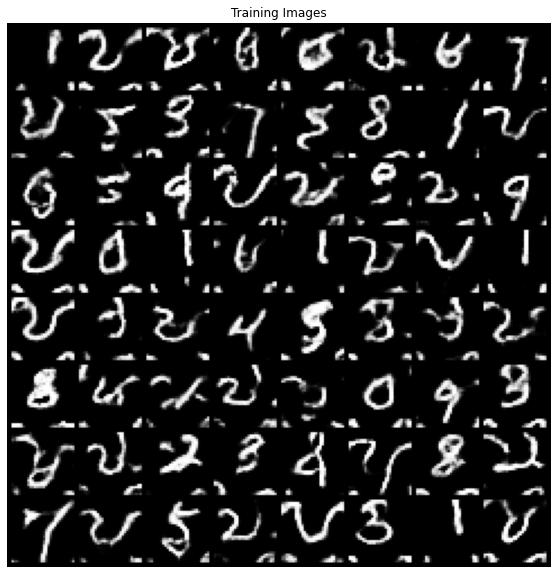

Epoch: [13][0/1093]	generator_loss: 1.1571 (1.1571)	discriminator_loss: 0.5347 (0.5347)	
Epoch: [13][200/1093]	generator_loss: 1.2613 (1.1601)	discriminator_loss: 0.5926 (0.5495)	
Epoch: [13][400/1093]	generator_loss: 1.5470 (1.1581)	discriminator_loss: 0.4308 (0.5502)	
Epoch: [13][600/1093]	generator_loss: 1.1735 (1.1682)	discriminator_loss: 0.5705 (0.5492)	
Epoch: [13][800/1093]	generator_loss: 1.3380 (1.1826)	discriminator_loss: 0.4648 (0.5478)	
Epoch: [13][1000/1093]	generator_loss: 1.0845 (1.1787)	discriminator_loss: 0.6898 (0.5492)	


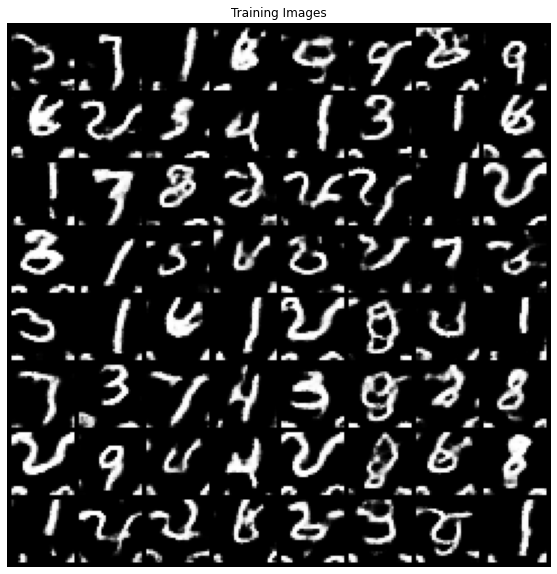

Epoch: [14][0/1093]	generator_loss: 1.0731 (1.0731)	discriminator_loss: 0.5358 (0.5358)	
Epoch: [14][200/1093]	generator_loss: 1.0753 (1.0953)	discriminator_loss: 0.6008 (0.5494)	
Epoch: [14][400/1093]	generator_loss: 1.2248 (1.1168)	discriminator_loss: 0.5409 (0.5518)	
Epoch: [14][600/1093]	generator_loss: 1.1687 (1.1326)	discriminator_loss: 0.5142 (0.5542)	
Epoch: [14][800/1093]	generator_loss: 1.0716 (1.1335)	discriminator_loss: 0.4730 (0.5533)	
Epoch: [14][1000/1093]	generator_loss: 1.0438 (1.1336)	discriminator_loss: 0.5554 (0.5560)	


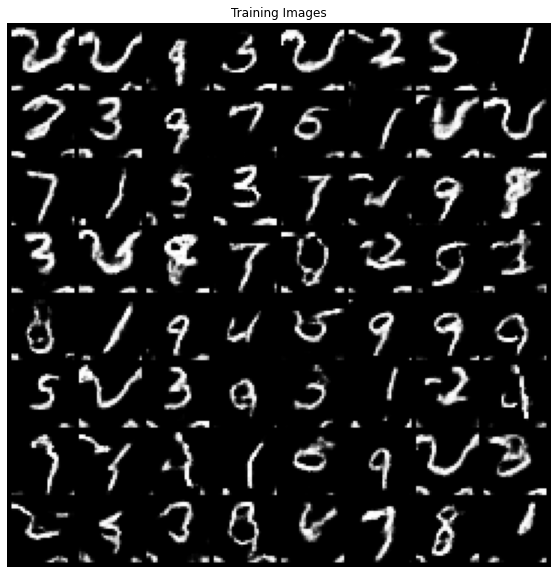

Epoch: [15][0/1093]	generator_loss: 1.0698 (1.0698)	discriminator_loss: 0.6078 (0.6078)	
Epoch: [15][200/1093]	generator_loss: 1.1607 (1.1581)	discriminator_loss: 0.5128 (0.5668)	
Epoch: [15][400/1093]	generator_loss: 1.2179 (1.1754)	discriminator_loss: 0.6164 (0.5660)	
Epoch: [15][600/1093]	generator_loss: 1.3420 (1.1627)	discriminator_loss: 0.4637 (0.5649)	
Epoch: [15][800/1093]	generator_loss: 1.1839 (1.1518)	discriminator_loss: 0.5865 (0.5637)	
Epoch: [15][1000/1093]	generator_loss: 1.1626 (1.1344)	discriminator_loss: 0.5201 (0.5659)	


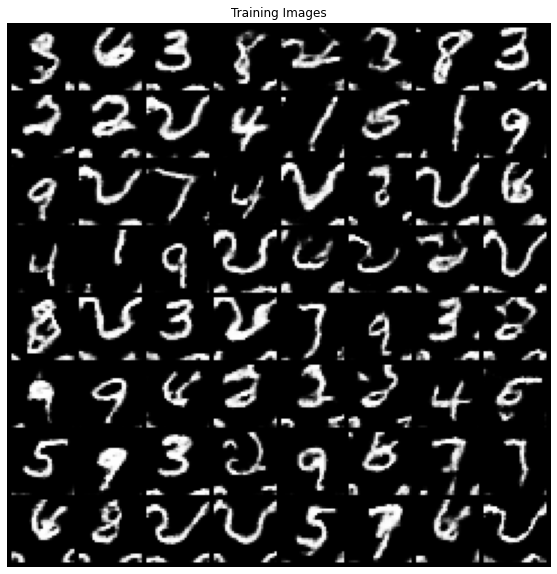

Epoch: [16][0/1093]	generator_loss: 0.7937 (0.7937)	discriminator_loss: 0.6690 (0.6690)	
Epoch: [16][200/1093]	generator_loss: 1.2208 (1.0765)	discriminator_loss: 0.5551 (0.5694)	
Epoch: [16][400/1093]	generator_loss: 1.2231 (1.0888)	discriminator_loss: 0.4940 (0.5701)	
Epoch: [16][600/1093]	generator_loss: 1.3346 (1.1066)	discriminator_loss: 0.4241 (0.5666)	
Epoch: [16][800/1093]	generator_loss: 1.0347 (1.1036)	discriminator_loss: 0.5753 (0.5696)	
Epoch: [16][1000/1093]	generator_loss: 0.9598 (1.0930)	discriminator_loss: 0.6705 (0.5711)	


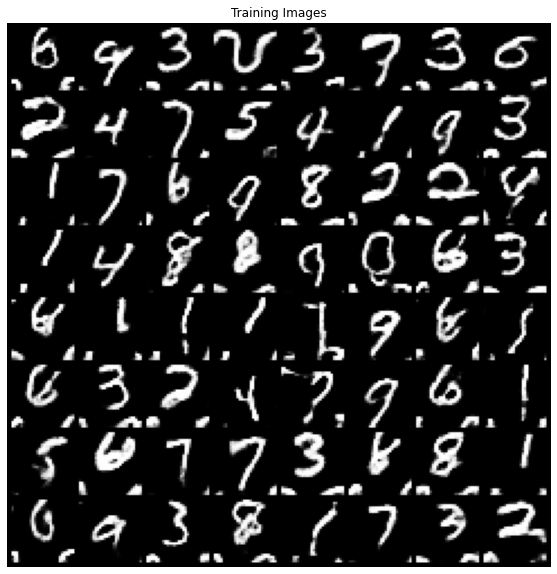

Epoch: [17][0/1093]	generator_loss: 1.0233 (1.0233)	discriminator_loss: 0.5178 (0.5178)	
Epoch: [17][200/1093]	generator_loss: 0.9690 (1.0442)	discriminator_loss: 0.5702 (0.5803)	
Epoch: [17][400/1093]	generator_loss: 0.9476 (1.0482)	discriminator_loss: 0.5792 (0.5769)	
Epoch: [17][600/1093]	generator_loss: 0.9188 (1.0556)	discriminator_loss: 0.6384 (0.5771)	
Epoch: [17][800/1093]	generator_loss: 1.2898 (1.0590)	discriminator_loss: 0.5124 (0.5768)	
Epoch: [17][1000/1093]	generator_loss: 0.8374 (1.0517)	discriminator_loss: 0.6133 (0.5772)	


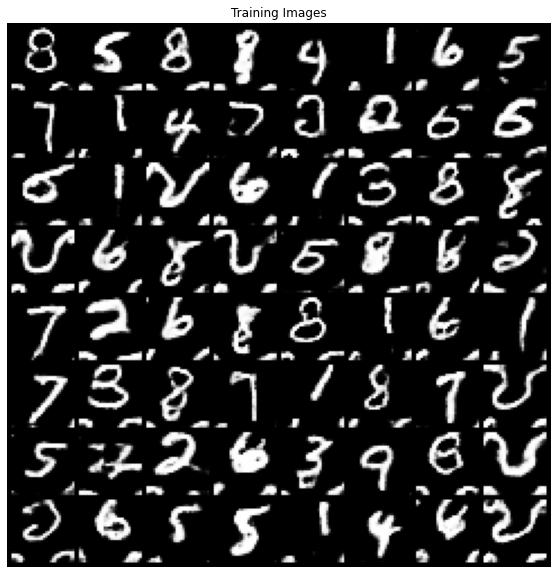

Epoch: [18][0/1093]	generator_loss: 1.0995 (1.0995)	discriminator_loss: 0.5570 (0.5570)	
Epoch: [18][200/1093]	generator_loss: 0.9728 (1.0375)	discriminator_loss: 0.5725 (0.5753)	
Epoch: [18][400/1093]	generator_loss: 0.9045 (1.0492)	discriminator_loss: 0.5781 (0.5772)	
Epoch: [18][600/1093]	generator_loss: 1.0142 (1.0791)	discriminator_loss: 0.6443 (0.5748)	
Epoch: [18][800/1093]	generator_loss: 1.0511 (1.0773)	discriminator_loss: 0.5434 (0.5753)	
Epoch: [18][1000/1093]	generator_loss: 0.9920 (1.0650)	discriminator_loss: 0.6106 (0.5759)	


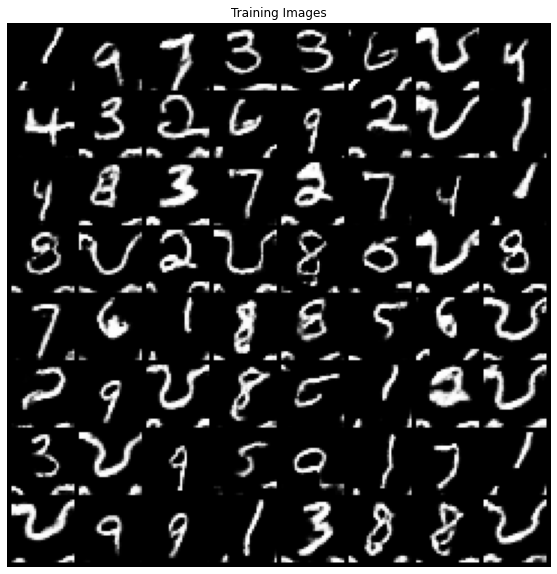

Epoch: [19][0/1093]	generator_loss: 0.9693 (0.9693)	discriminator_loss: 0.5936 (0.5936)	
Epoch: [19][200/1093]	generator_loss: 1.0916 (1.0576)	discriminator_loss: 0.5830 (0.5809)	
Epoch: [19][400/1093]	generator_loss: 1.0000 (1.0389)	discriminator_loss: 0.5929 (0.5797)	
Epoch: [19][600/1093]	generator_loss: 0.8257 (1.0217)	discriminator_loss: 0.6022 (0.5841)	
Epoch: [19][800/1093]	generator_loss: 1.1339 (1.0171)	discriminator_loss: 0.6093 (0.5837)	
Epoch: [19][1000/1093]	generator_loss: 1.0708 (1.0131)	discriminator_loss: 0.5941 (0.5831)	


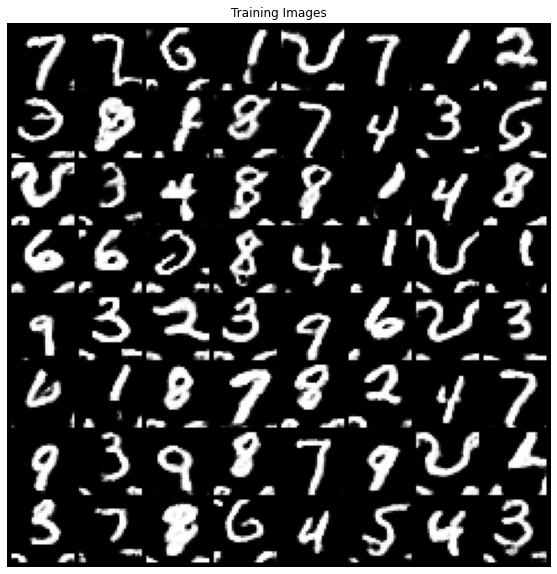

In [31]:
for epoch in range(epochs) :
    generator.train()
    discriminator.train()
    
    gen_loss_tracker = AverageMeter()
    disc_loss_tracker = AverageMeter()
    
    for i, (images, labels) in enumerate(train_loader):
        labels = F.one_hot(labels, num_classes=num_classes)
        images = images.to(device)
        labels = labels.to(device)
        
        random_latent_vectors = torch.randn(batch_size, latent_dim)
        random_latent_vectors = random_latent_vectors.to(device)
    
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake, _ = discriminator(generated_images, labels)
        predictions_real, _ = discriminator(images, labels)
        combined_predictions = torch.cat(
            (predictions_fake, predictions_real), 0
        )
        
        gt_labels = torch.cat(
            (torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), 0
        ).to(device)
        
        d_loss = criterion(combined_predictions, gt_labels)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(device)
        
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake_to_real, tmp = discriminator(generated_images, labels)
    
        misleading_labels = torch.zeros(batch_size, 1).to(device)
        
        g_loss = criterion(predictions_fake_to_real, misleading_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        disc_loss_tracker.update(np.mean(d_loss.item()))
        gen_loss_tracker.update(np.mean(g_loss.item()))
        if i % 200 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'generator_loss: {gen_loss_tracker.val:.4f} ({gen_loss_tracker.avg:.4f})\t'
                  'discriminator_loss: {disc_loss_tracker.val:.4f} ({disc_loss_tracker.avg:.4f})\t'
                  .format(epoch, i, len(train_loader),
                          gen_loss_tracker=gen_loss_tracker,
                          disc_loss_tracker=disc_loss_tracker))
            

    plt.figure(figsize=(10,10)) 
    plt.axis("off") 
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(generated_images[:64].detach().to('cpu'), 
                                             padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

In [14]:
tmp[0,1:,0,0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)

In [15]:
tmp[0,1:,:,:]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [32]:
num_interpolation = 9
interpolation_noise = torch.randn(1, latent_dim)
interpolation_noise = torch.repeat_interleave(interpolation_noise, num_interpolation)
interpolation_noise = torch.reshape(interpolation_noise, (num_interpolation, latent_dim))
interpolation_noise = interpolation_noise.to(device)

def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = F.one_hot(torch.tensor([first_number]), num_classes)
    second_label = F.one_hot(torch.tensor([second_number]), num_classes)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = torch.linspace(0, 1, num_interpolation)[:, None]
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    ).to(device)

    fake = generator(interpolation_noise, interpolation_labels)
    return fake
start_class = 3  
end_class = 8  

fake_images = interpolate_class(start_class, end_class)

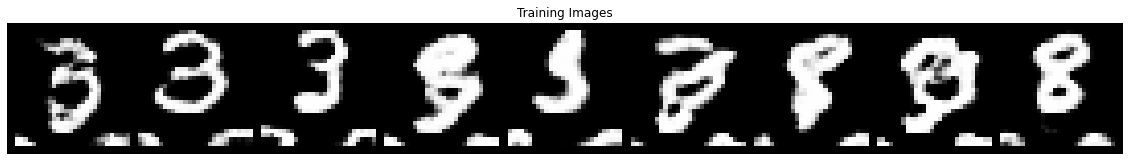

In [33]:
plt.figure(figsize=(20,20)) 
plt.axis("off") 
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.detach().to('cpu'), nrow=10,
                                         padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()